In [1]:
import pmdarima as pm
import pandas as pd
import matplotlib.pyplot as plt
import fxcmpy
import datetime as dt
import warnings
warnings.filterwarnings('ignore') 

# Import data
TOKEN = 'ccf0e2248bf73ca5f37919cc53913fa67935cea4'
con = fxcmpy.fxcmpy(access_token=TOKEN, log_level='error', server='real')
start = dt.datetime(2010, 1, 1)
stop = dt.datetime(2020, 11, 25)
data = con.get_candles('EUR/USD', period='D1',start=start, stop=stop,columns=['asks', 'tickqty'],with_index=False)

# Rename the columns
data.rename(columns = {'askopen':'open',
                       'askclose':'close',
                       'askhigh':'high',
                       'asklow':'low',
                       'tickqty':'volume'}, inplace = True) 

In [2]:
data.dtypes

date      datetime64[ns]
open             float64
close            float64
high             float64
low              float64
volume             int64
dtype: object

In [3]:
data = data[['date','close']]

In [4]:
data.set_index('date',inplace=True)

In [5]:
data

,close
date,
2010-01-04 22:00:00,1.44144
2010-01-05 22:00:00,1.43676
2010-01-06 22:00:00,1.44091
2010-01-07 22:00:00,1.43104
2010-01-08 22:00:00,1.44156
...,...
2020-11-20 22:00:00,1.18583
2020-11-22 22:00:00,1.18571
2020-11-23 22:00:00,1.18421


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3235 entries, 2010-01-04 22:00:00 to 2020-11-25 22:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   3235 non-null   float64
dtypes: float64(1)
memory usage: 50.5 KB


<AxesSubplot:xlabel='date'>

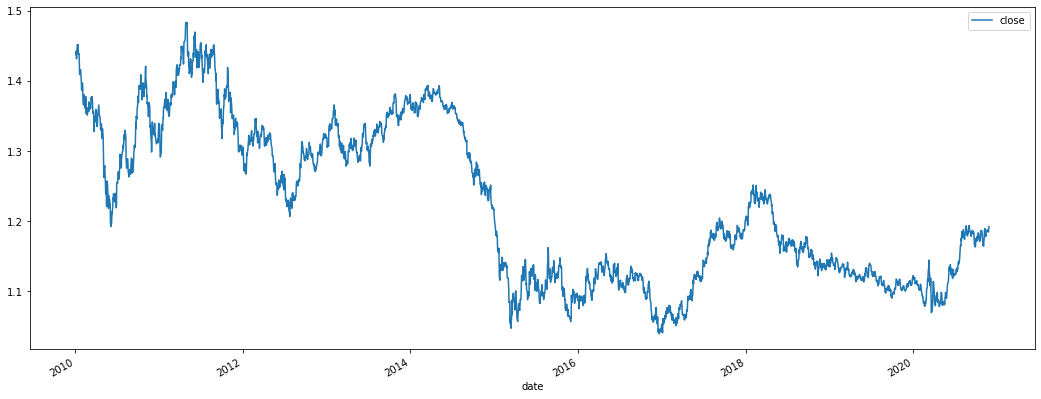

In [7]:
data.plot(figsize=(18,7))

Stationarity is an important concept in time-series and any time-series data should undergo a stationarity test before proceeding with a model.
We use the ‘Augmented Dickey-Fuller Test’ to check whether the data is stationary or not which is available in the ‘pmdarima’ package.

In [8]:
#Testing for stationarity
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(data)

(0.4521741106336554, True)

From the above, we can conclude that the data is stationary. However, we still try to use the “Integrated (I)” concept, denoted by value ‘d’ in time series to make the data stationary while building the Auto ARIMA model.


In [9]:
dataset = data.values
dataset

array([[1.44144],
       [1.43676],
       [1.44091],
       ...,
       [1.18421],
       [1.18981],
       [1.19204]])

In [10]:
import math
training_data_len = math.ceil(len(dataset)*0.8)
training_data_len

2588

In [11]:
#Spliting the dataset into train and test
train = data[:training_data_len]
test = data[training_data_len:]

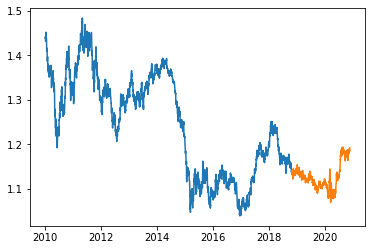

In [12]:
plt.plot(train)
plt.plot(test)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3235 entries, 2010-01-04 22:00:00 to 2020-11-25 22:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   3235 non-null   float64
dtypes: float64(1)
memory usage: 50.5 KB


In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(x = data, model='multiplicative', period=365)
result

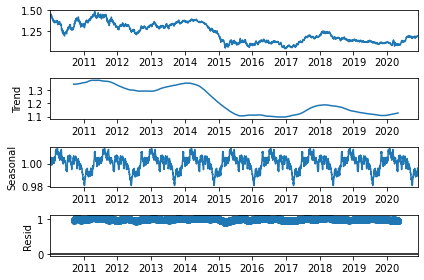

In [20]:
result.plot()
plt.show()

In [21]:
from pmdarima.arima import auto_arima
stepwise_model =  auto_arima(data,start_p=0, d=1, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=12, seasonal=True, 
                          error_action='ignore',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )

Performing stepwise search to minimize aic


c:\users\habiw\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-21096.485, Time=0.79 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-22082.219, Time=1.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=13.06 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-21097.914, Time=0.41 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-22463.664, Time=4.69 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=-22748.256, Time=11.69 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=-22863.572, Time=19.67 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=-22942.125, Time=41.30 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=-22917.141, Time=65.51 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=93.96 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=-22943.857, Time=17.86 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=-22865.372, Time=13.05 sec
 ARIMA(0,1,0)(5,1,1)[12]             : AIC=-22907.701, Time=34.90 sec
 ARIMA(0,1,0)(4,1,1)[12]             : AIC=-22830.281, Time=19.49 sec
 ARIMA(0,1,1)(5,1,0)[12]             :

In [22]:
#Summary of the model
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 3235
Model:             SARIMAX(0, 1, 0)x(5, 1, 0, 12)   Log Likelihood               11477.929
Date:                            Sat, 28 Nov 2020   AIC                         -22943.857
Time:                                    14:02:28   BIC                         -22907.391
Sample:                                         0   HQIC                        -22930.788
                                           - 3235                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.8704      0.014    -62.370      0.000      -0.898      -0.843
ar.S.L24      -0.7142      0.019    -37.944      0.000      -0.751      -0.677
ar.S.L36      -0.5445      0.020    -27.922      0.000      -0.583      -0.506
ar.S.L48      -0.3236      0.018    -17.551      0.000      -0.360      -0.287
ar.S.L60      -0.1565      0.014    -10.865      0.000      -0.185      -0.128
sigma2      4.691e-05   8.06e-07     58.225      0.000    4.53e-05    4.85e-05
===================================================================================
Ljung-Box (Q):                       76.58   Jarque-Bera (JB):               662.45
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.29   Skew:                            -0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
stepwise_model.fit(train)

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(5, 1, 0, 12),
      with_intercept=False)

In [26]:
print(stepwise_model.aic())

-17976.55590878021


In [23]:
prediction = pd.DataFrame(stepwise_model.predict(n_periods = len(test)),index=test.index)
prediction.columns = ['predicted_prices']
prediction.tail()

,predicted_prices
date,
2020-11-20 22:00:00,1.406921
2020-11-22 22:00:00,1.409192
2020-11-23 22:00:00,1.409088
2020-11-24 22:00:00,1.406359
2020-11-25 22:00:00,1.407294


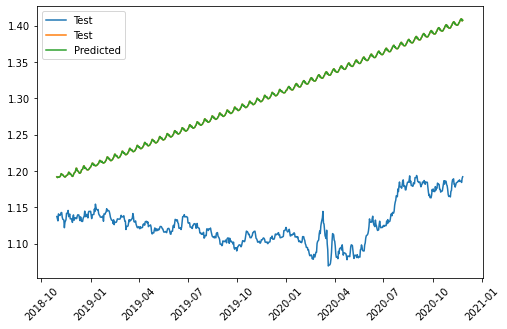

In [32]:
plt.figure(figsize=(8,5))
#plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'upper left')
plt.xticks(rotation=45)
plt.show()

In [27]:
# 9 months predicion
future_forecast = stepwise_model.predict(n_periods=len(test)+9)
future_forecast

array([1.14112753, 1.14160343, 1.14130653, 1.14066977, 1.13910777,
       1.13841125, 1.13969697, 1.13959201, 1.13924691, 1.13973459,
       1.13748116, 1.13733165, 1.13964772, 1.13956157, 1.13844477,
       1.13955612, 1.14003332, 1.13996838, 1.14030918, 1.14128874,
       1.14045731, 1.13967127, 1.13637622, 1.13620718, 1.13770681,
       1.1361493 , 1.1339629 , 1.13555346, 1.13503126, 1.13504336,
       1.13427724, 1.13499654, 1.13401517, 1.13468438, 1.13207598,
       1.13179381, 1.13362331, 1.13267245, 1.12945508, 1.13089862,
       1.13167053, 1.13172172, 1.13012091, 1.130811  , 1.12877859,
       1.12798517, 1.12632705, 1.12598411, 1.12710935, 1.12627599,
       1.12297498, 1.12326017, 1.12408745, 1.12405565, 1.12270105,
       1.12315517, 1.12170956, 1.12255048, 1.12083012, 1.12023817,
       1.12227376, 1.12173413, 1.11895003, 1.11887495, 1.11984594,
       1.1197747 , 1.11866602, 1.11927226, 1.11708226, 1.11680456,
       1.11525864, 1.1148436 , 1.11656543, 1.11591671, 1.11377

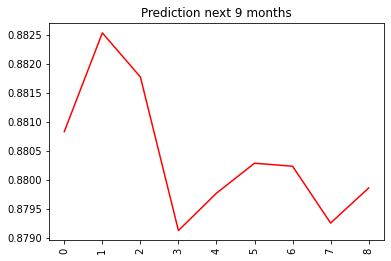

In [31]:
plt.plot(future_forecast[len(test):], color='red')
plt.xticks(rotation='vertical')
plt.title("Prediction next 9 months")
plt.show()

In [29]:
from sklearn.metrics import r2_score
test['predicted_prices'] = prediction
r2_score(test['close'], test['predicted_prices'])

c:\users\habiw\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


-39.05725580560667

Summary
In this article, we tried to use the functionality of the Auto ARIMA model and this approach will come into handy if you would like to generate the p, d, and q values from the model itself. In the basic ARIMA or SARIMA model, you need to perform differencing and plot ACF and PACF graphs to determine these values which are time-consuming.
However, it is always advisable to go with statistical techniques and implement the basic ARIMA model to understand the intuitive behind the p,d, and q values if you are new to time series.